# Predicting Pulsar Star
Pulsar candidates collected during the High Time Resolution Universe Survey
- original dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2
- kaggle competition: https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate 

### About Dataset
**Description**

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted,which treat the candidate data sets as binary classification problems.

Credit goes to Pavan Raj (https://www.kaggle.com/pavanraj159) from where the dataset has been collected. For the purpose of creating a challenge, certain modifications have been done to the dataset.

Original dataset can be acquired from the link Predicting a Pulsar Star (https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star)
Attribute Information:

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve . These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

HTRU 2 Summary
17,898 total examples.
1,639 positive examples.
16,259 negative examples.

Source: https://archive.ics.uci.edu/ml/datasets/HTRU2

Dr Robert Lyon
University of Manchester
School of Physics and Astronomy
Alan Turing Building
Manchester M13 9PL
United Kingdom
robert.lyon '@' manchester.ac.uk

## Imports

In [2]:
import joblib
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


## EDA

In [56]:
#sns.set(style="darkgrid")
#plt.style.use('fivethirtyeight')

In [3]:
# read data and rename column names for better readability and clarity.
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df_train = pd.read_csv('data/pulsar_data_train.csv')
df_test = pd.read_csv('data/pulsar_data_test.csv')

df_train.columns = new_columns
df_test.columns = new_columns
df_train.head()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [4]:
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


No duplicates in data

In [5]:
# basic informations of trainset
display(df_train.describe())
df_train.info()
df_train.isna().sum()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      12528 non-null  float64
 1   Profile_std       12528 non-null  float64
 2   Profile_kurtosis  10793 non-null  float64
 3   Profile_skewness  12528 non-null  float64
 4   DM_SNR_mean       12528 non-null  float64
 5   DM_SNR_std        11350 non-null  float64
 6   DM_SNR_kurtosis   12528 non-null  float64
 7   DM_SNR_skewness   11903 non-null  float64
 8   target            12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


Profile_mean           0
Profile_std            0
Profile_kurtosis    1735
Profile_skewness       0
DM_SNR_mean            0
DM_SNR_std          1178
DM_SNR_kurtosis        0
DM_SNR_skewness      625
target                 0
dtype: int64

In [6]:
# kaggle test
#display(df_test.head())
display(df_test.describe())
df_test.info()
df_test.isna().sum()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
count,5370.000000,5370.000000,4603.000000,5370.000000,5370.000000,4846.000000,5370.000000,5126.000000,0.0
mean,111.168917,46.615074,0.483676,1.751260,12.473587,26.425371,8.233724,102.869088,NaN
std,25.608635,6.940638,1.076893,6.072820,29.145134,19.384489,4.435683,104.748418,NaN
min,6.179688,24.791612,-1.876011,-1.764717,0.213211,7.370432,-2.721857,-1.964998,NaN
25%,101.041016,42.408020,0.030643,-0.189557,1.956522,14.555826,5.700461,33.817330,NaN
50%,114.757812,47.031304,0.227314,0.186468,2.830686,18.549670,8.383695,81.392046,NaN
75%,127.023438,51.133444,0.475056,0.918807,5.590301,28.681787,10.632265,136.893502,NaN
max,192.617188,98.778911,7.608370,65.385974,223.392141,109.712649,34.539844,1191.000837,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      5370 non-null   float64
 1   Profile_std       5370 non-null   float64
 2   Profile_kurtosis  4603 non-null   float64
 3   Profile_skewness  5370 non-null   float64
 4   DM_SNR_mean       5370 non-null   float64
 5   DM_SNR_std        4846 non-null   float64
 6   DM_SNR_kurtosis   5370 non-null   float64
 7   DM_SNR_skewness   5126 non-null   float64
 8   target            0 non-null      float64
dtypes: float64(9)
memory usage: 377.7 KB


Profile_mean           0
Profile_std            0
Profile_kurtosis     767
Profile_skewness       0
DM_SNR_mean            0
DM_SNR_std           524
DM_SNR_kurtosis        0
DM_SNR_skewness      244
target              5370
dtype: int64

There are missing values in: 
- **Excess kurtosis of the integrated profile**,
- **Standard deviation of the DM-SNR curve** and
- **Skewness of the DM-SNR curve**

in both datasets (train and test). The test dataset does not contain any values for the target class and is used as the aim dataset.

In [7]:
print('Missing values in % (trainset)')
print('---'*20)
df_train.isna().sum()/len(df_train)*100

Missing values in % (trainset)
------------------------------------------------------------


Profile_mean         0.000000
Profile_std          0.000000
Profile_kurtosis    13.848978
Profile_skewness     0.000000
DM_SNR_mean          0.000000
DM_SNR_std           9.402937
DM_SNR_kurtosis      0.000000
DM_SNR_skewness      4.988825
target               0.000000
dtype: float64

In [8]:
print('Missing values in % (testset)')
print('---'*20)
df_test.isna().sum()/len(df_test)*100

Missing values in % (testset)
------------------------------------------------------------


Profile_mean          0.000000
Profile_std           0.000000
Profile_kurtosis     14.283054
Profile_skewness      0.000000
DM_SNR_mean           0.000000
DM_SNR_std            9.757914
DM_SNR_kurtosis       0.000000
DM_SNR_skewness       4.543762
target              100.000000
dtype: float64

In both datasets, the percentage of missing data is roughly the same. The following section aims to investigate how the missing data can be handled to improve the quality of data analysis and modeling.

target
0.0    11375
1.0     1153
Name: count, dtype: int64


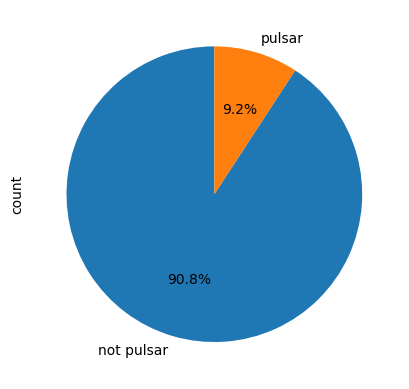

In [9]:
# target distribution
df_train['target'].value_counts().plot(kind='pie', autopct='%.1f%%', startangle=90, labels=['not pulsar', 'pulsar'])
print(df_train['target'].value_counts())

The data is highly imbalanced. Only 9.2% of the datapoints is classified as pulsar.

<Axes: >

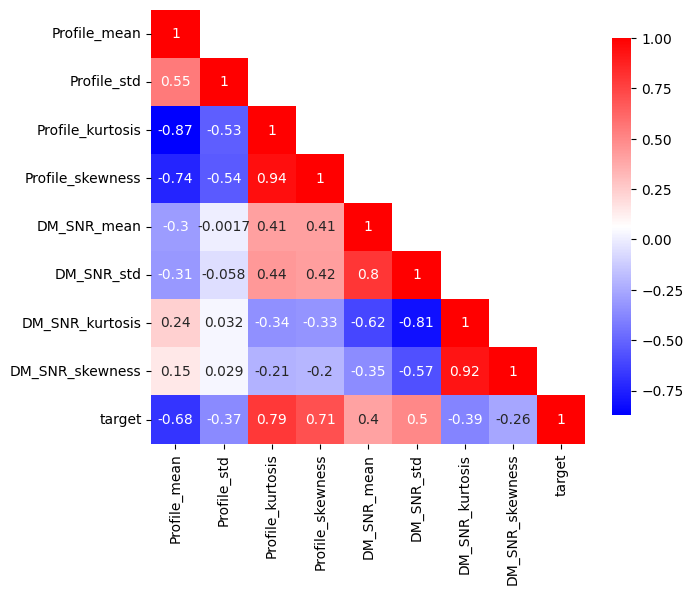

In [10]:
# correlations of the features
corr_matrix = df_train.corr()

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=corr_matrix,
            annot=True,
            square=True,
           cbar_kws={"shrink": .7},
           cmap='bwr',
           mask=np.triu(corr_matrix,+1))

The following features have a high correlation:

* Profile_mean and Profile_skewness
* Profile_mean and Profile_kurtosis
* Profile_kurtosis and Profile_skewness

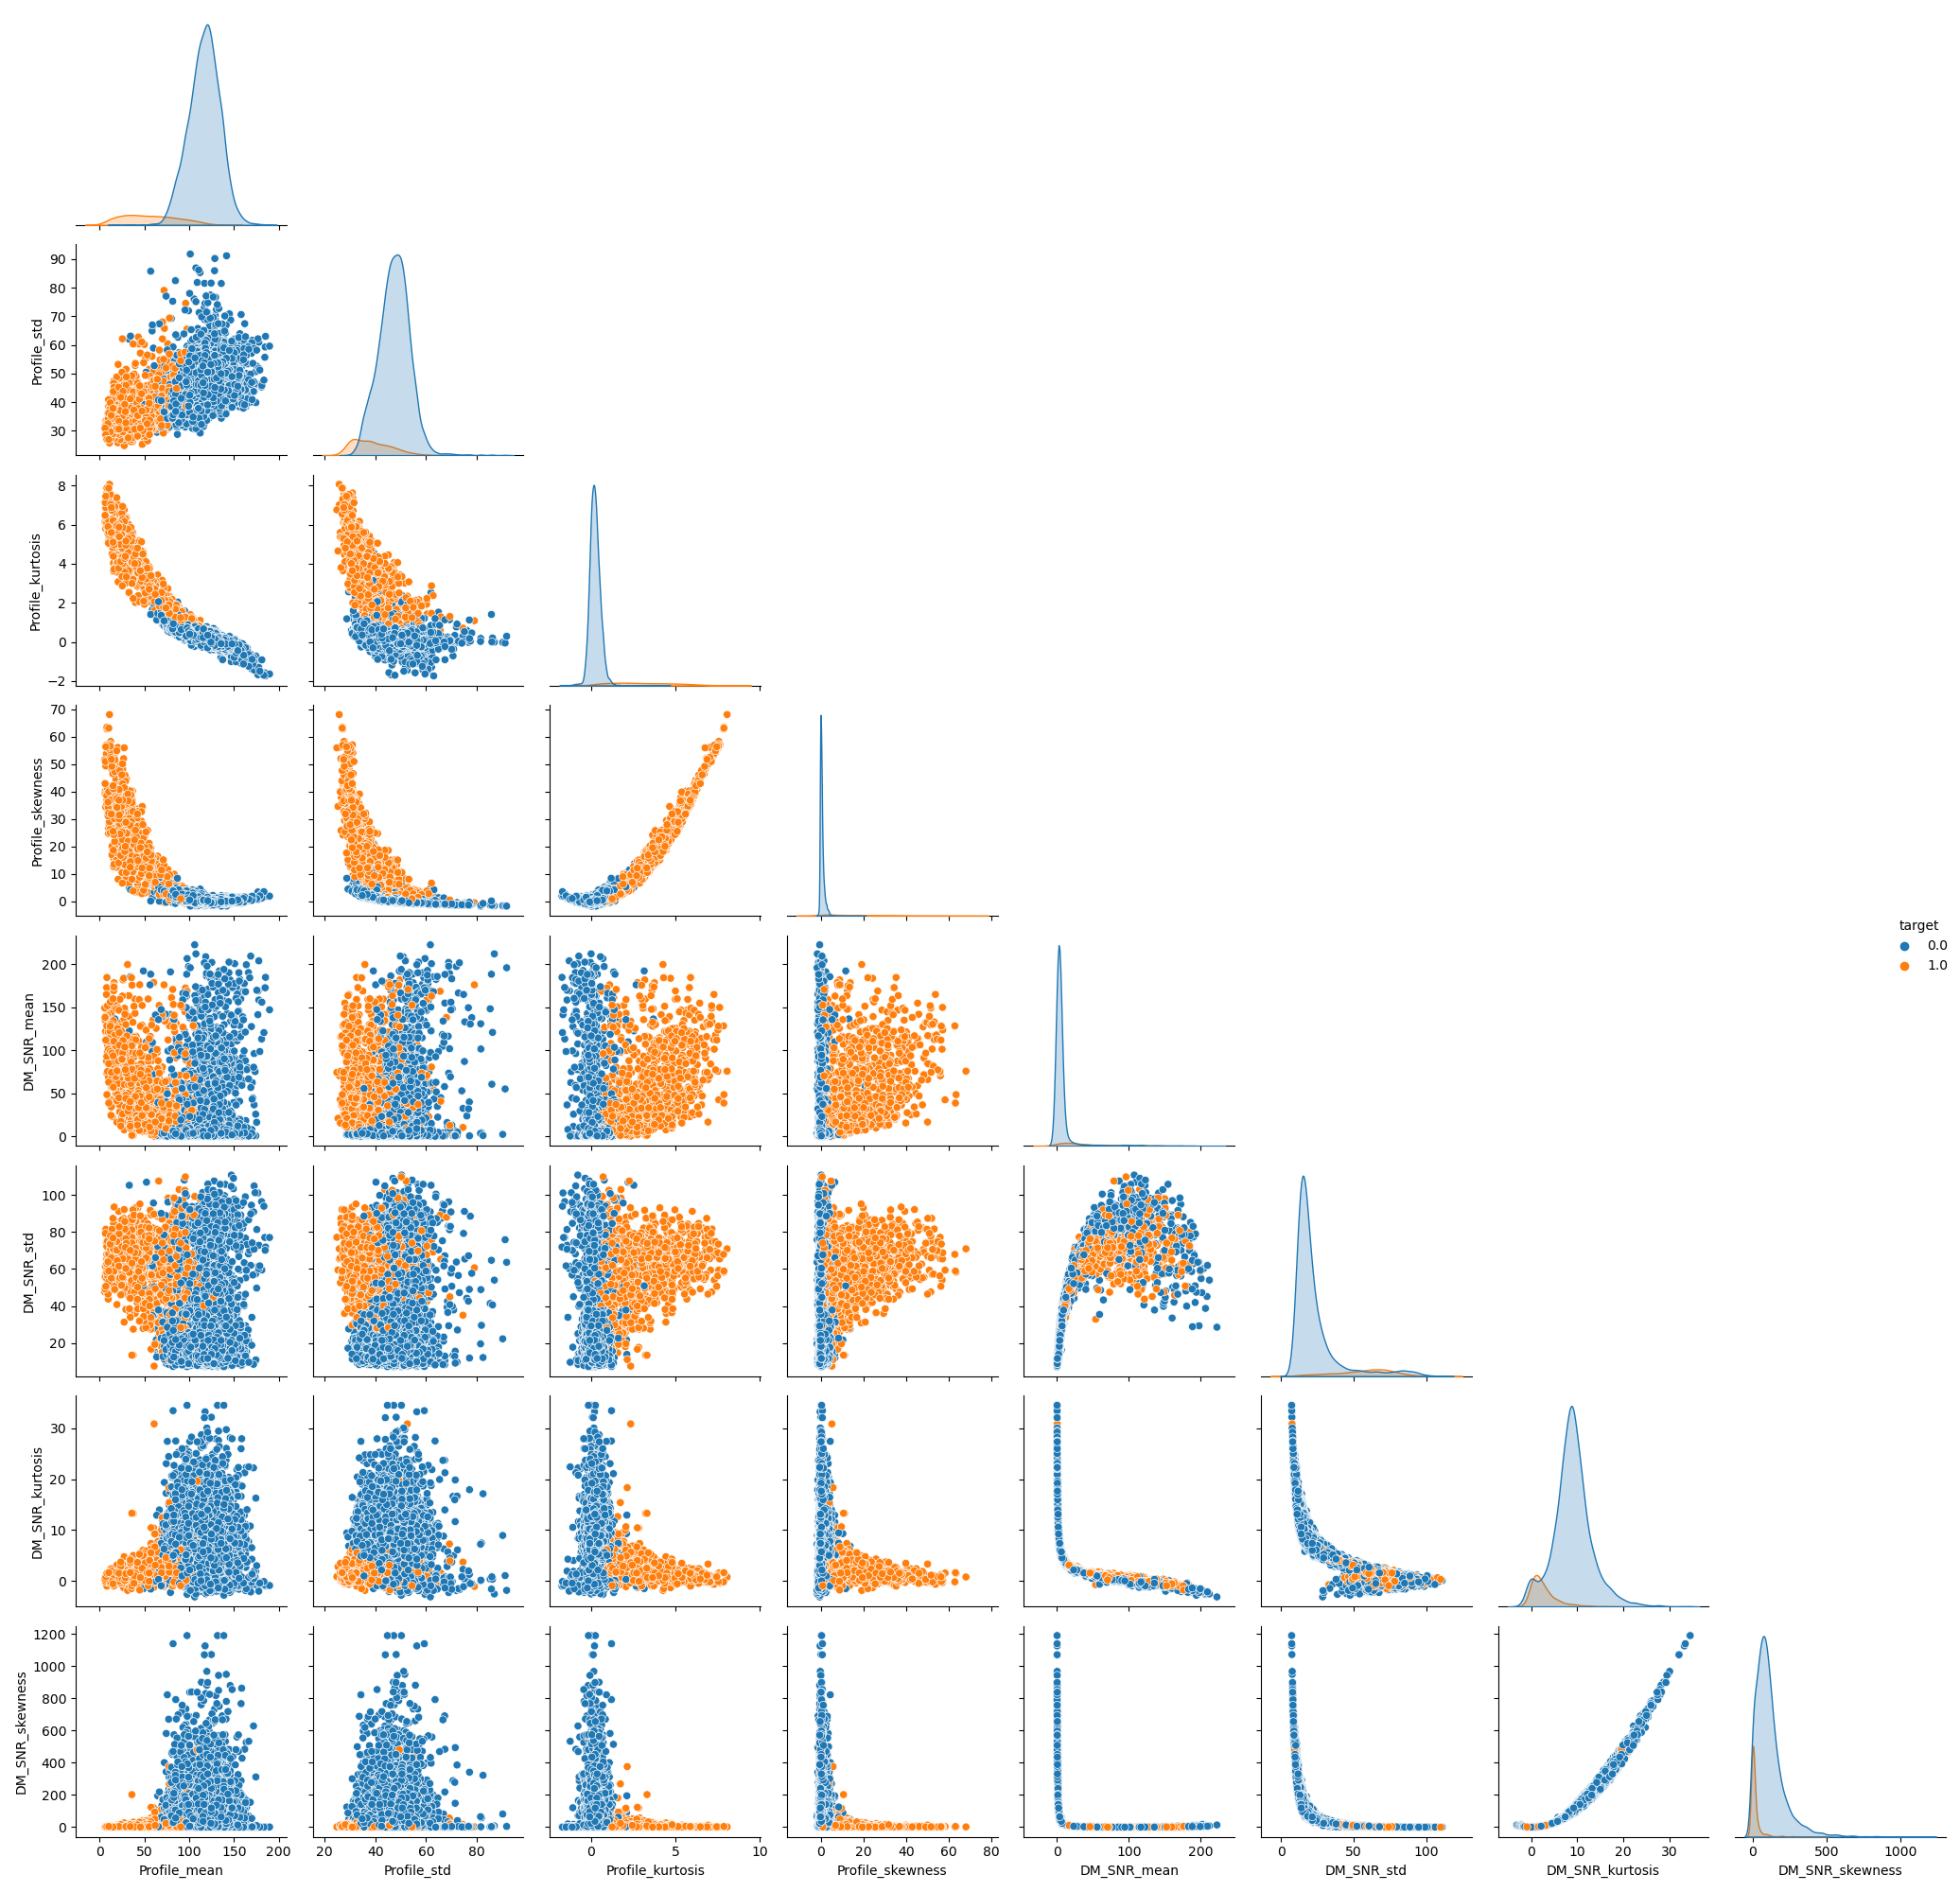

In [139]:
# check distribution of each feature
save_flag = 0

if save_flag == 1:
    
    sns.pairplot(data=df_train, hue='target', corner=True)
    plt.tight_layout()
    plt.savefig('plots/pairplot_train_data.png')

Image('plots/pairplot_train_data.png')

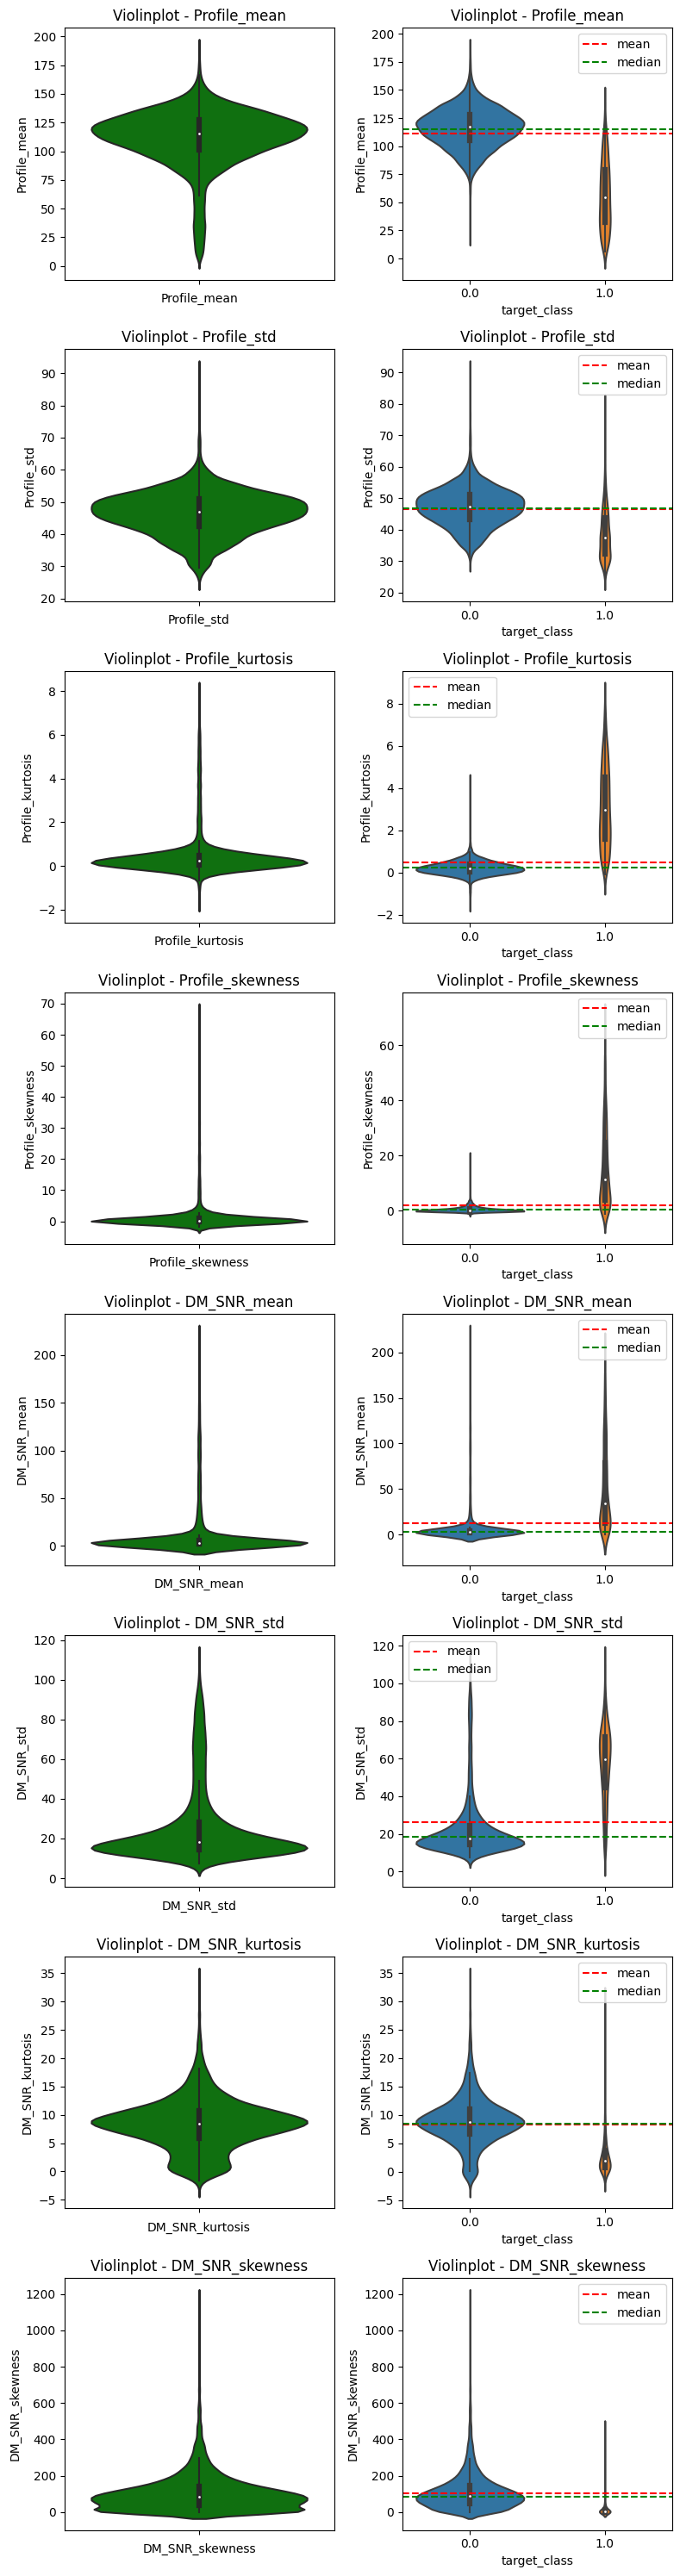

In [11]:
features = df_train.columns.to_list()

fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(8, 30))
for i, feature in enumerate(features[:-1]):
    ax1 = axs[i,0]
    ax2 = axs[i,1]

    sns.violinplot(y=feature, data=df_train, ax=ax1, color='g')
    ax1.set_xlabel(feature)
    ax1.set_title('Violinplot - ' + feature)
    
    sns.violinplot(x=features[-1], y=feature, data=df_train, ax=ax2, scale='count')
    ax2.set_xlabel('target_class')
    ax2.set_ylabel(feature)
    ax2.set_title('Violinplot - ' + feature)
    ax2.axhline(df_train[feature].mean(), color='r', linestyle='--', label='mean')
    ax2.axhline(df_train[feature].median(), color='g', linestyle='--', label='median')
    ax2.legend()
    
plt.tight_layout()

plt.show()

Based on the analysis of the pairplot and the visualization of the features in the violin plot, it appears that the outlier data points correspond to the targets we are interested in. Therefore, we will not specifically address or handle these outliers as they align with our objectives.

## Train-Validation-Test Split
The test set obtained from Kaggle does not include the target variable,
so it is no longer useful and can be repurposed as the aim dataset.

For modeling purposes, we will perform a train-validation-test split with a distribution of 70-15-15.
This allows us to allocate 70% of the data for training, 15% for testing, and 15% for validation.

In [12]:
# perform train-validation-test split
#read in again to remove previous changes
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df = pd.read_csv('data/pulsar_data_train.csv')
df.columns = new_columns

In [13]:
# define features and target
features = df.drop(columns='target')
target = df['target']


# First split: Training data and rest (validation data + test data)
X_train, X_rest, y_train, y_rest = train_test_split(features, target,
                                                    test_size=0.3,
                                                    random_state=42)

# Second split: Test data and validation data
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest,
                                                test_size=0.5,
                                                random_state=42)

In [69]:
# save X_test as 'X_test.csv' and y_test as 'y_test.csv'

X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

**Now we have:**
- X_train: Training data
- y_train: Target for training data
- X_test: Test data
- y_test: Target for test data
- X_val: Validation data
- y_val: Target for validation data

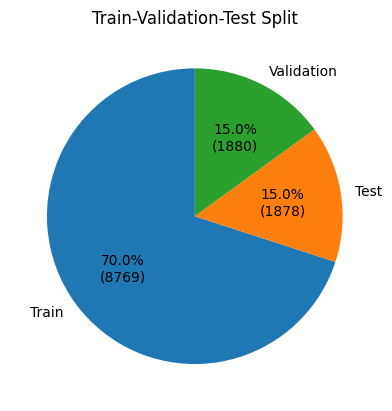

In [14]:
# visualize the split
counts = [len(X_train), len(X_test), len(X_val)]

def my_fmt(x):
    total = sum(counts)
    absolute = int(x / 100. * total)
    return '{:.1f}%\n({:})'.format(x, absolute)

plt.pie(counts, labels=['Train', 'Test', 'Validation'], autopct=my_fmt, startangle=90)
plt.title('Train-Validation-Test Split')
plt.show()

## Clean Data

In [15]:
# Handle missing values
num_cols = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness']

cat_cols = []


cleaner = ColumnTransformer(transformers=[("knn_imputer", KNNImputer(n_neighbors=5, weights="uniform"), num_cols)],
                            remainder = "passthrough"
                           )
# save fitted cleaner
joblib.dump(cleaner, 'models/fitted_cleaner.pkl')

# apply imputing on datasets
X_train = pd.DataFrame(cleaner.fit_transform(X_train), columns=num_cols)
X_val = pd.DataFrame(cleaner.transform(X_val), columns=num_cols)
X_test = pd.DataFrame(cleaner.transform(X_test), columns=num_cols)

#print(X_train.info(), X_test.info(), X_val.info())

### Save Imputer 

In [72]:
# Save the fitted ColumnTransformer to a file in the models folder
if not os.path.exists('models'):
    os.makedirs('models')   
with open('models/cleaner.pkl', 'wb') as f:
    pickle.dump(cleaner, f)

# Example for Loading:
# # Load the fitted ColumnTransformer from the file in the models folder
# with open('models/cleaner.pkl', 'rb') as f:
#     cleaner = pickle.load(f)

# # Use the loaded ColumnTransformer to transform new data
# X_cleaned = cleaner.transform(X_new)

# Modeling
For the of predicting of pulsar stars, three models are used: Support Vector Machine (SVM), Random Forest (RF) and Artificial Neural Network (ANN). 
Each model has its own strengths and limitations and offers different approaches to the task.
By using these different models, we aim to explore different prediction strategies and evaluate their performance using the pulsar star dataset.

The calculate_scores function computes evaluation metrics for comparing different models in the context of predicting pulsar stars.

In [16]:
# helper function to compare the scores of the different models
model_results = []

def calculate_scores(y_val, y_pred, name):
    """
    Calculates and returns the accuracy, precision, recall, and F1 score for the given validation and predicted labels.

    Args:
        y_val (array-like): The true labels for the validation set.
        y_pred (array-like): The predicted labels for the validation set.
        name (str): The name of the model used to make the predictions.

    Returns:
        dict: A dictionary containing the name of the model and the calculated accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1_scr = f1_score(y_val, y_pred)

    scores = {'name': name,
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'F1': f1_scr,
              }

    return scores

## Random Forest

First steps for the Random Forest model is to set up a baseline model to get a rough understanding of its pridictions with a classification report. This is there also for me to refer back to in order to know I am improving the model later on.

In [17]:
# Baseline model for general impressions
model_rf = Pipeline(steps = [("scaler", StandardScaler()),
                             ("rfc", RandomForestClassifier(n_estimators = 10,
                                                         max_depth = 5,
                                                         random_state = 42,
                                                         n_jobs = -1))]
                   )

# Baseline model trialed for results
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)
print(classification_report(y_pred_rf, y_val))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1723
         1.0       0.80      0.93      0.86       157

    accuracy                           0.97      1880
   macro avg       0.90      0.95      0.92      1880
weighted avg       0.98      0.97      0.98      1880



Next steps are to set up a pipeline which will include the scaler as well as the Random Forest model with more parameters as the goal now is to find the best parameters for the model which will be done using a grid search with cross validation.

In [18]:
# Pipeline set up 
model_std_rfc = Pipeline([("scaler", StandardScaler()),
                           ("rfc", RandomForestClassifier(n_estimators = 10,
                                                          class_weight = "balanced",
                                                          max_depth = 5,
                                                          max_leaf_nodes = 5,
                                                          random_state = 42,
                                                          n_jobs = -1))])

# Parameters search spaces
n_estimator_space = np.geomspace(10, 1000, 15, dtype="int")
max_depth_space = np.geomspace(1, 10, 5, dtype="int")
max_leaf_nodes_space = np.geomspace(2, 10, 5, dtype="int")

search_space = {"rfc__n_estimators" : [26],
                "rfc__max_depth" : [3],
               "rfc__max_leaf_nodes": [10]}

# Grid search looking for best parameters
grid_search = GridSearchCV(estimator = model_std_rfc,
                          param_grid = search_space,
                          scoring = "f1",
                          cv =5,
                          n_jobs = -1)

# Grid search fitted and results printed
grid_search.fit(X_train, y_train)

print(grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_)

0.8429190247426528 Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        max_leaf_nodes=10, n_estimators=26,
                                        n_jobs=-1, random_state=42))]) {'rfc__max_depth': 3, 'rfc__max_leaf_nodes': 10, 'rfc__n_estimators': 26}


With the best parameters found for my model, I will input them into a final pipeline below to train the model to its best potential.

In [19]:
# Final parameters applied to the model
model_std_rfc = Pipeline([("scaler", StandardScaler()),
                           ("rfc", RandomForestClassifier(n_estimators = 26,
                                                          class_weight = "balanced",
                                                          max_depth = 3,
                                                          max_leaf_nodes = 10,
                                                          random_state = 42,
                                                          n_jobs = -1))])

# Model fitted and used to predict using the validation data set 
model_std_rfc.fit(X_train, y_train)
y_val_pred = model_std_rfc.predict(X_val)
f1_string = "F1 score is: "
print(f1_string, f1_score(y_val, y_val_pred))

F1 score is:  0.8457446808510638


With the model having been trained and test with the validation data set I can then move on to testing it with the test data set and get another overview of how it fairs and its output will later on be compared to the other models to find the best suited model for the projects goal.

In [20]:
# Testing the model using the test data set
y_test_pred = model_std_rfc.predict(X_test)
print(f1_string, f1_score(y_test, y_test_pred))

F1 score is:  0.8508287292817679


Steps to appened the final measurements into a dataframe that will accumulate all final results from the models to come.

In [21]:
model_results.append(calculate_scores(y_test, y_test_pred, name='RF_Grid'))

pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,RF_Grid,0.971261,0.806283,0.900585,0.850829


### RF - Evaluation on Test Data

Visuals help to get a better understanding of what is happening with the results and to see what the model is predicting or what it struggles with predicting. 

------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9899    0.9783    0.9841      1708
         1.0     0.8063    0.9006    0.8508       171

    accuracy                         0.9713      1879
   macro avg     0.8981    0.9395    0.9175      1879
weighted avg     0.9732    0.9713    0.9720      1879

ROC_AUC_Score : 0.9790613829656107
------------------------------------------------------------


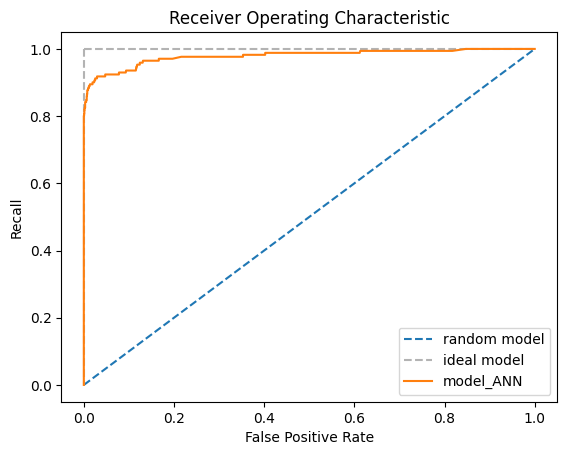

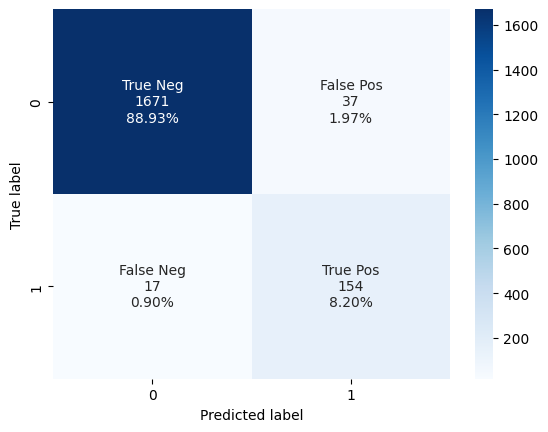

In [22]:
# predict on test data and print results --------------------------------------------------------------
y_pred = model_std_rfc.predict(X_test)
y_pred_proba = model_std_rfc.predict_proba(X_test)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba[:, 1]))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba[:, 1],
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

### RF - Feature Importance

Feature Importance will demonstrate to us which specific columns will have a greater influence on the model in each model as well and can be used later on as a comparison if desired. The main focus is to make the graph easily legiable and to demonstrate how the column Profile_kurtosis has a strong influence in the Random Forest decision making.

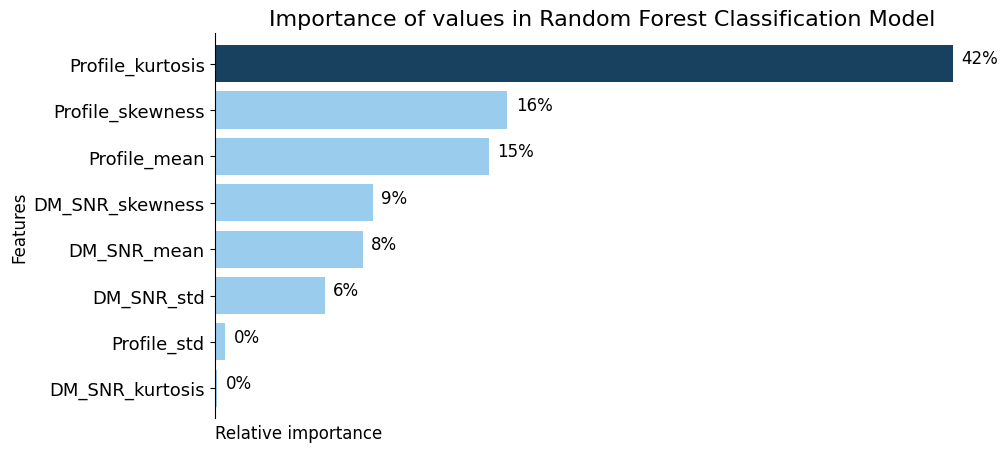

In [23]:
# Setting up to calculate the feature importance first before being able to plot it
# Organised ascendingly
model_std_rfc.steps

RFC_feat_importance = pd.Series(data=model_std_rfc.steps[1][1].feature_importances_,
                                index=X_train.columns)
RFC_feat_importance_sorted = RFC_feat_importance.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#99cced']*7 + ['#17415f']

RFC_feat_importance_sorted.plot(kind="barh", color=colors, width = 0.8);

# Customisations------------------------------------------------------------------------------------------
ax.set_title(label="Importance of values in Random Forest Classification Model",
            size = 16)
ax.set_xlabel('Relative importance',
             size = 12,
             position=[0, 0],
             horizontalalignment='left')
ax.set_yticklabels(ax.get_yticklabels(), 
                   size=13)
ax.set_ylabel('Features',
              size = 12)

for idx in range(len(RFC_feat_importance_sorted.index)):
    ax.text(s='{}%'.format(int(100*RFC_feat_importance_sorted.iloc[idx])),
            x=RFC_feat_importance_sorted.iloc[idx]+0.005,
            y=idx, size=12,
            color='black'
           )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([]);

### RF - Plot Tree

Visual representation of the first tree within the collection of forest in the Random Forest model.

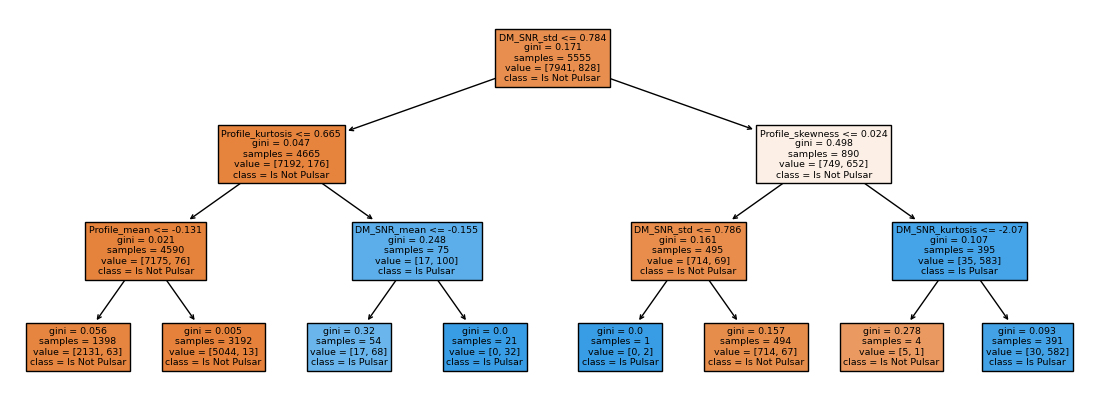

In [81]:
# Visualisation of the first tree in forest
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,5))
tree.plot_tree(model_std_rfc.named_steps["rfc"].estimators_[0],
               feature_names = X_train.columns, 
               class_names=["Is Not Pulsar", "Is Pulsar"],
               filled = True);

fig.savefig('rfc_individualtree_[0].png')

### RF - Save Model

In [82]:
# Save the fitted model to a file in the models folder
if not os.path.exists('models'):
    os.makedirs('models')
with open('models/rfc_pulsar_gridsearch_20230612.pkl', 'wb') as f:
    pickle.dump(model_std_rfc, f)

## Support Vector Machine (SVM)
This code creates a pipeline that first scales the data using `StandardScaler`, then applies the `SMOTE` algorithm to balance the classes, and finally fits an `SVC` model. The pipeline is then fit on the training data and used to make predictions on the validation data. The performance of the model is evaluated using a classification report.


In [24]:
# Create a pipeline that scales the data and applies SMOTE
pipe = make_pipeline(StandardScaler(), SMOTE(), SVC())

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on new data
y_pred_baseline = pipe.predict(X_val)

print(classification_report(y_pred_baseline, y_val))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1683
         1.0       0.88      0.81      0.84       197

    accuracy                           0.97      1880
   macro avg       0.93      0.90      0.91      1880
weighted avg       0.97      0.97      0.97      1880



### SVM - GridSearch
This code performs a grid search to find the best hyperparameters for an `SVC` model within the specified `param_grid`. The grid search is performed using 5-fold cross-validation and all available CPU cores. The best hyperparameters are then used to create a new pipeline with the same preprocessing steps as before, but with an `SVC` model using the best hyperparameters. This new pipeline is fit on the training data and used to make predictions on the validation data. The best hyperparameters found by the grid search are also printed.


In [25]:
# all non-used options are commented out to increase the execution speed of the notebook 
param_grid = {
    'svc__C': [10], # 0.01, 0.1, 1, 10, 100
    'svc__kernel': ['rbf'], # 'linear', 'poly', 'sigmoid'
    'svc__gamma': [0.01], # 0.01, 0.1, 1, 10, 100
    'svc__degree': [2] # 3, 4
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Remove the 'svc__' prefix from the keys in best_params_
best_params = {key.split('__')[1]: value for key, value in grid.best_params_.items()}

model_SVM_grid = make_pipeline(StandardScaler(), SMOTE(), SVC(**best_params, probability=True))
model_SVM_grid.fit(X_train, y_train)
y_pred_grid = model_SVM_grid.predict(X_val)

print(best_params)

{'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [26]:
print(f1_score(y_val, y_val_pred))

0.8457446808510638


In [27]:
y_test_svm_pred = model_SVM_grid.predict(X_test)

In [28]:
model_results.append(calculate_scores(y_test, y_test_svm_pred, name='SVM_Grid'))

pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,RF_Grid,0.971261,0.806283,0.900585,0.850829
1,SVM_Grid,0.975519,0.830688,0.918129,0.872222


### SVM - Evaluation on Test Data
To assess the model's performance on the test data, a classification report and the ROC-AUC score are printed. Additionally, a ROC curve is plotted, and a confusion matrix is displayed.

------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9917    0.9813    0.9865      1708
         1.0     0.8307    0.9181    0.8722       171

    accuracy                         0.9755      1879
   macro avg     0.9112    0.9497    0.9293      1879
weighted avg     0.9771    0.9755    0.9761      1879

ROC_AUC_Score : 0.983329224701097
------------------------------------------------------------


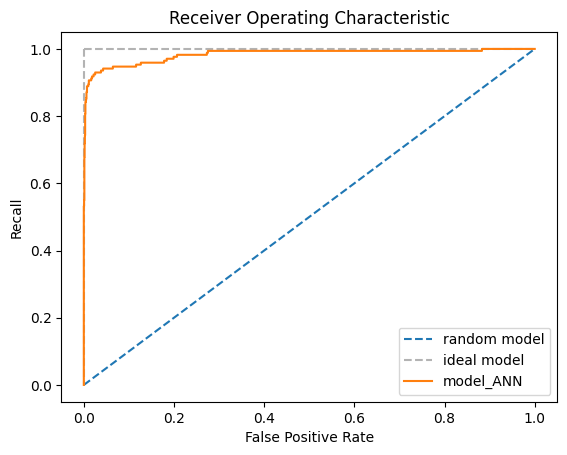

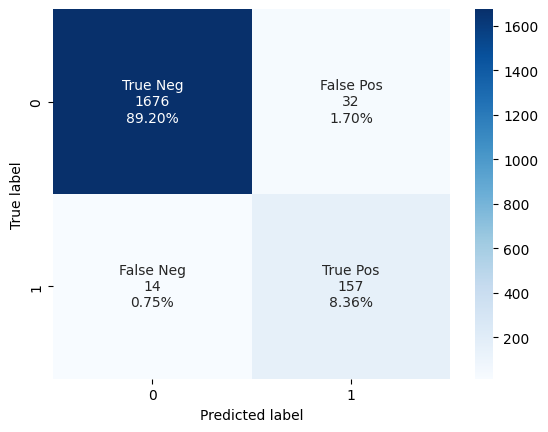

In [29]:
# predict on test data and print results --------------------------------------------------------------
y_pred = model_SVM_grid.predict(X_test)
y_pred_proba = model_SVM_grid.predict_proba(X_test)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba[:, 1]))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba[:, 1],
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

### SVM - Feature Importance

In [30]:
# Calculate permutation importance
result = permutation_importance(model_SVM_grid, X_val, y_val, n_repeats=1, random_state=42)

svm_feature_names = X_train.columns
svm_feat_importance = pd.DataFrame({'Feature': svm_feature_names, 'Importance': result.importances_mean})

# Set negative importance scores to zero
svm_feat_importance['Importance'] = np.maximum(svm_feat_importance['Importance'], 0)

# Convert the importance scores to percentages
svm_total_importance = svm_feat_importance['Importance'].sum()
svm_feat_importance['Importance'] = 100 * svm_feat_importance['Importance'] / svm_total_importance
svm_feat_importance_sorted = svm_feat_importance.sort_values(by='Importance', ascending=True).set_index('Feature')

C:\Users\Dabbel\AppData\Local\Temp\ipykernel_17576\2903155004.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=13)


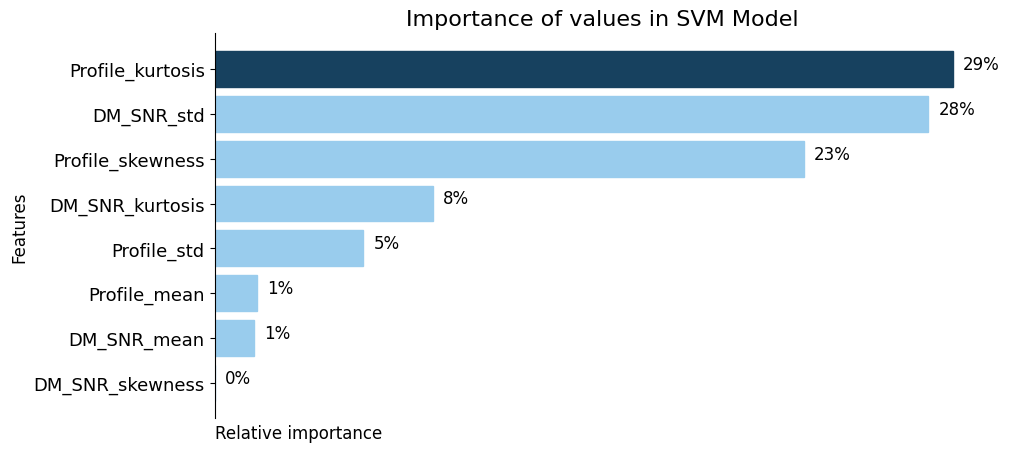

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#99cced']*7 + ['#17415f']
bars = ax.barh(svm_feat_importance_sorted.index, svm_feat_importance_sorted['Importance'], color=colors[0], height=0.8)

# Set the color of each bar individually
for i, bar in enumerate(bars):
    if i < len(colors):
        bar.set_color(colors[i])
    else:
        bar.set_color(colors[-1])

ax.set_title(label="Importance of values in SVM Model", size=16)
ax.set_xlabel('Relative importance', size=12, position=[0, 0], horizontalalignment='left')
ax.set_yticklabels(ax.get_yticklabels(), size=13)
ax.set_ylabel('Features', size=12)

for idx in range(len(svm_feat_importance_sorted.index)):
    ax.text(s='{}%'.format(int(svm_feat_importance_sorted.iloc[idx].values[0])),
            x=svm_feat_importance_sorted.iloc[idx].values[0]+0.405,
            y=idx, size=12,
            color='black'
           )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([]);

Based on the feature importance results, it appears that the most important features for the `SVM` model are `Profile_kurtosis`, `DM_SNR_std`, and `Profile_skewness`, with relative importance scores of 30%, 28%, and 22%, respectively. The least important feature is `DM_SNR_skewness`, with a relative importance score of 0%.


### SVM - Save Model

In [92]:
# Save the fitted model to a file in the models folder
if not os.path.exists('models'):
    os.makedirs('models')
with open('models/svm_pulsar_gridsearch_20230612.pkl', 'wb') as f:
    pickle.dump(model_SVM_grid, f)

In [32]:
# show results
pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,RF_Grid,0.971261,0.806283,0.900585,0.850829
1,SVM_Grid,0.975519,0.830688,0.918129,0.872222


## Neural Network (ANN)

The model performance is trained and evaluated using the F1 score metric, which is not included as a standard metric in Keras. 
To overcome this limitation, a custom function called f1_score_ann is defined. 
This function calculates the F1 score by computing precision and recall, allowing for a comprehensive evaluation of the model's performance.
See article: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d 

In [33]:
# define f1 score 
def f1_score_ann(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

### ANN - Baseline

The data is preprocessed for the ANN model by scaling it using StandardScaler.
This ensures standardized feature values. Additionally, SMOTE is applied to address class imbalance by oversampling the minority class.

In [34]:
# preprocessing for ANN
scaler = StandardScaler()

# apply preprocessing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset distribution of', y_train.value_counts())
print('Resampled dataset distribution of', y_train_sampled.value_counts())

Original dataset distribution of target
0.0    7969
1.0     800
Name: count, dtype: int64
Resampled dataset distribution of target
0.0    7969
1.0    7969
Name: count, dtype: int64


The ANN is constructed with two hidden layers, each employing a ReLU activation function. The number of units in the hidden layers is set to match the number of input features, ensuring the model can effectively capture the data's complexity and patterns. Dropout layers are incorporated for regularization to prevent overfitting.

The input layer of the ANN is designed to accommodate the preprocessed data's feature dimensions. By experimenting with different layouts, it has been determined that this particular architecture yields the best performance for the given task. The output layer consists of a single unit employing a sigmoid activation function, making it suitable for binary classification. The determination of the number of neurons and hidden layers in a neural network is not guided by a fixed formula or rule. 

In general, it is commonly observed that utilizing one to two hidden layers in a neural network architecture is often sufficient to achieve good performance for most problems. Adding more layers or increasing the number of neurons does not necessarily guarantee improved results and may even lead to overfitting, especially when the dataset is limited. This principle is emphasized in the literature, such as in the book "Hands-On Machine Learning with Scikit-Learn, Keras" by Aurélien Géron.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None


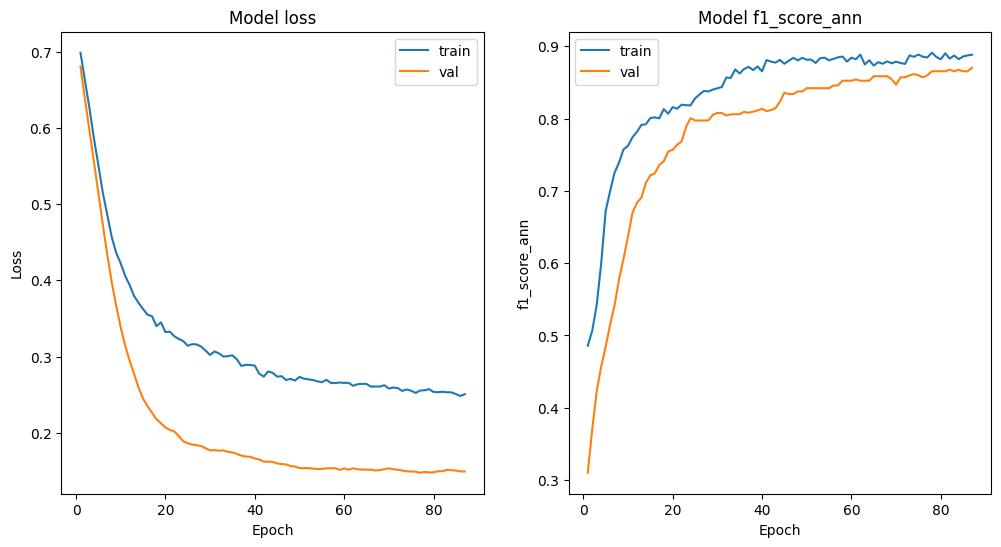

In [35]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow)
tf.keras.utils.set_random_seed(42)

#dropout rate for dropout layers
dropout_rate = 0.5

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=8, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=8, activation='relu')

# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)
print(model_ann.summary())
#-----------------------------------------------------------------------------------------
# Optimizer
adam_custom = Adam(learning_rate=0.0005) #default 0.001

#-----------------------------------------------------------------------------------------
# compile model    
model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])

#---------------------------------------------------------------------------------------------
# early stopping for regularization
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10)

# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=512,
                         verbose=0,
                         callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))

# plot loss function and score of used metrics ---------------------------------------------------

# define figure and axes
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# plot training & validation loss values
axs[0].plot(range(1, len(hist_ann.history['loss']) + 1), hist_ann.history['loss'])
axs[0].plot(range(1, len(hist_ann.history['val_loss']) + 1), hist_ann.history['val_loss'])
axs[0].set(title='Model loss', ylabel='Loss', xlabel='Epoch')
axs[0].legend(['train', 'val'])

# plot training & validation metric score values
axs[1].plot(range(1, len(hist_ann.history[model_ann.metrics_names[1]]) + 1), hist_ann.history[model_ann.metrics_names[1]])
axs[1].plot(range(1, len(hist_ann.history['val_' + model_ann.metrics_names[1]]) + 1), hist_ann.history['val_' + model_ann.metrics_names[1]])
axs[1].set(title='Model ' + model_ann.metrics_names[1], ylabel=model_ann.metrics_names[1], xlabel='Epoch')
axs[1].legend(['train', 'val'], loc='upper left')

In [36]:
# Predict and print classification report of validation data------------------------------------------------------------
y_pred = (model_ann.predict(X_val_scaled) > 0.5).astype('int8')
y_true = y_val
print(classification_report(y_true, y_pred, digits=4))

59/59 [==============================] - 0s 794us/step
              precision    recall  f1-score   support

         0.0     0.9848    0.9894    0.9871      1698
         1.0     0.8966    0.8571    0.8764       182

    accuracy                         0.9766      1880
   macro avg     0.9407    0.9233    0.9317      1880
weighted avg     0.9762    0.9766    0.9764      1880



The model achieved a high accuracy of 0.977 on the validation data, indicating strong overall predictive capability. The F1-score for the positive class (class 1) was 0.88, suggesting good performance in identifying positive cases. These results imply that the model shows promise in accurately classifying the target variable using the provided features.

### ANN - Evaluation on Test Data
To assess the model's performance on the test data, a classification report and the ROC-AUC score are printed. Additionally, a ROC curve is plotted, and a confusion matrix is displayed.

 1/59 [..............................] - ETA: 1s

59/59 [==============================] - 0s 725us/step
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9889    0.9871    0.9880      1708
         1.0     0.8736    0.8889    0.8812       171

    accuracy                         0.9782      1879
   macro avg     0.9312    0.9380    0.9346      1879
weighted avg     0.9784    0.9782    0.9783      1879

ROC_AUC_Score : 0.9776182258926003
------------------------------------------------------------


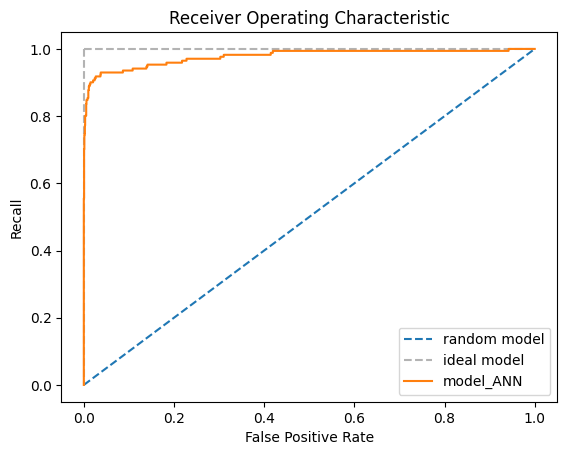

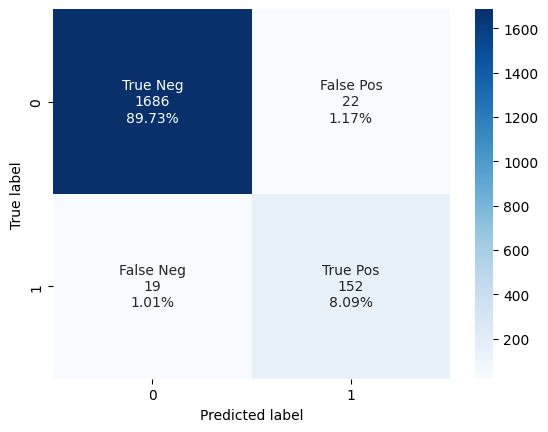

In [37]:
# predict on test data and print results --------------------------------------------------------------
y_pred = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba = model_ann.predict(X_test_scaled)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

### ANN - Feature Importance

Since the ANN model does not have a built-in function to determine feature importance, permutation importance is used as an alternative method. This technique allows us to assess the impact of each feature on the model's performance.

The process involves the following steps:
1. The original F1 score of the model is computed using the true labels and predicted labels.
2. For each feature, the values are permuted to create a new dataset with the feature values shuffled.
3. The model's predictions are obtained using the permuted dataset, and the F1 score is calculated.
4. The difference between the original F1 score and the permuted F1 score is recorded as the feature importance.
5. The permutation is reset to its original state for the next feature, and the process is repeated.
6. The feature importances are stored in a series and sorted in ascending order.
7. Finally, a horizontal bar plot is created to visualize the feature importances.

59/59 [==============================] - 0s 656us/step


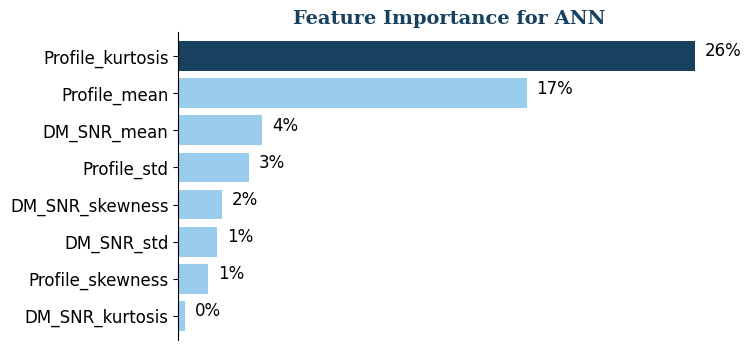

In [38]:
# original score from model
score_orig = f1_score(y_true, y_pred)

# create list for results
perm_importances = []

# features dataframe
df_features = pd.DataFrame(X_test_scaled)
df_features.columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
                              'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness']

features_test_perm = df_features.copy()
y_true = y_test

# list of features used for permutation
perm_features = df_features.columns.to_list()

# apply permutation
for col in perm_features:
    
    col_perm = (features_test_perm.loc[:, [col]]
            .sample(frac=1, replace=False, random_state=0)
            .reset_index(drop=True)
            .set_index(features_test_perm.index)
           )
    features_test_perm[col] = col_perm
   
    # evaluate permutated dataset
    y_pred_perm = (model_ann.predict(features_test_perm) > 0.5).astype('int8')
    score_perm = f1_score(y_true, y_pred_perm)
    
    perm_importances.append(score_orig-score_perm)
    
    # reset permutation
    features_test_perm.loc[:, col] = df_features.loc[:, col]

#print(perm_importances)

# Convert feature importance array into a series and visualize
feature_importance = pd.Series(perm_importances, index=perm_features).sort_values()

# plot feature importance
colors = ['#99cced']*7 + ['#17415f']
fig, ax = plt.subplots(figsize=(7, 4))

# only plot positive values and sort
mask = feature_importance > 0
feature_importance = feature_importance[mask]
feature_importance = feature_importance.sort_values()


feature_importance.plot(kind='barh', color=colors, width=0.8);

ax.set_title(label='Feature Importance for ANN',
             family='serif',
             color=colors[-1],
             weight='semibold',
             size=14
            )

ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for idx in range(len(feature_importance.index)):
    ax.text(s='{}%'.format(int(100*feature_importance.iloc[idx])),
            x=feature_importance.iloc[idx]+0.005,
            y=idx, size=12,
            color='black'
           )

ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([]);

The feature importance analysis reveals that the Profile_kurtosis feature accounts for more than 25% of the predictive power in the classification problem. This indicates that the kurtosis of the integrated profile plays a significant role in determining the target variable for the ANN. Additionally, the Profile_mean feature also contributes significantly to the prediction. The remaining features have relatively lower importance values compared to these two dominant ones.

In [39]:
# append results to model_results dataframe
model_results.append(calculate_scores(y_true, y_pred, name='ANN'))
pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,RF_Grid,0.971261,0.806283,0.900585,0.850829
1,SVM_Grid,0.975519,0.830688,0.918129,0.872222
2,ANN,0.978180,0.873563,0.888889,0.881159


###  ANN - Polynominal Features and PCA

The following steps involve applying polynomial transformation of the features of the order of 3 and Principal Component Analysis (PCA) to improve the performance of the Neural Network. These techniques aim to enhance the model's ability to capture intricate relationships between variables and reduce the dimensionality of the input features.

Original dataset shape (8769, 8)
Resampled train dataset shape (15938, 24)
Resampled test dataset shape (1879, 24)
explained_variance_ratio:  0.9949786109288863


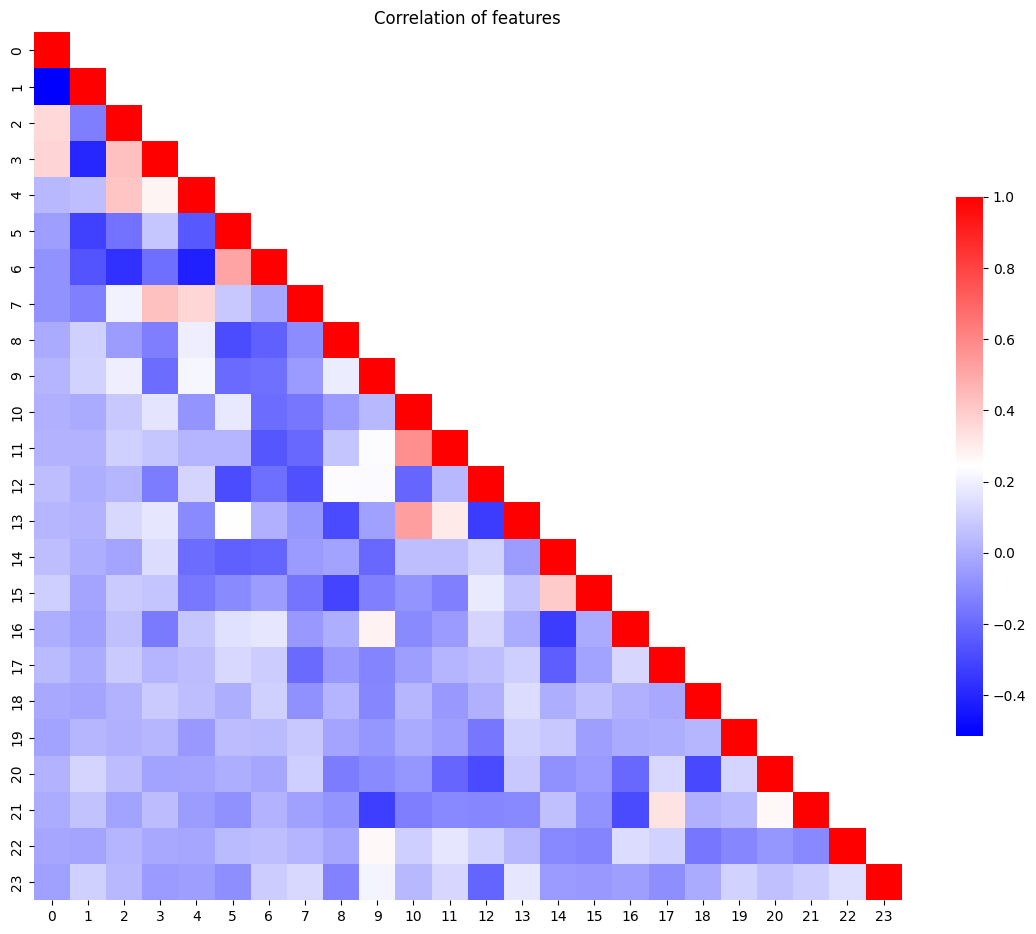

In [40]:
# preprocessing for ANN
from sklearn.preprocessing import MinMaxScaler, RobustScaler
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=24))
])



# apply preprocessing
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
X_val_scaled = pipeline.transform(X_val)


# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset shape', X_train.shape)
print('Resampled train dataset shape', X_train_sampled.shape)
print('Resampled test dataset shape', X_test_scaled.shape)
print('explained_variance_ratio: ',   pipeline.named_steps['pca'].explained_variance_ratio_.sum())

#---------------------------------------------------------
# visualize correlation matrix after poly and PCA
df_corr = pd.DataFrame(X_train_sampled)
corr_matrix = df_corr.corr()
fig, axs = plt.subplots(figsize=(14,14))
heatmap= sns.heatmap(data=corr_matrix,
                     #annot=True,
                     square=True,
                     cbar_kws={"shrink": .5},
                     cmap='bwr',
                     mask=np.triu(corr_matrix,+1))
heatmap.set_title('Correlation of features');


In [134]:
# Save the fitted pipeline in the models folder

save_flag = 0

if save_flag == 1:
    joblib.dump(pipeline, 'models/fitted_ANN_preprocessing_pipeline.pkl')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


None


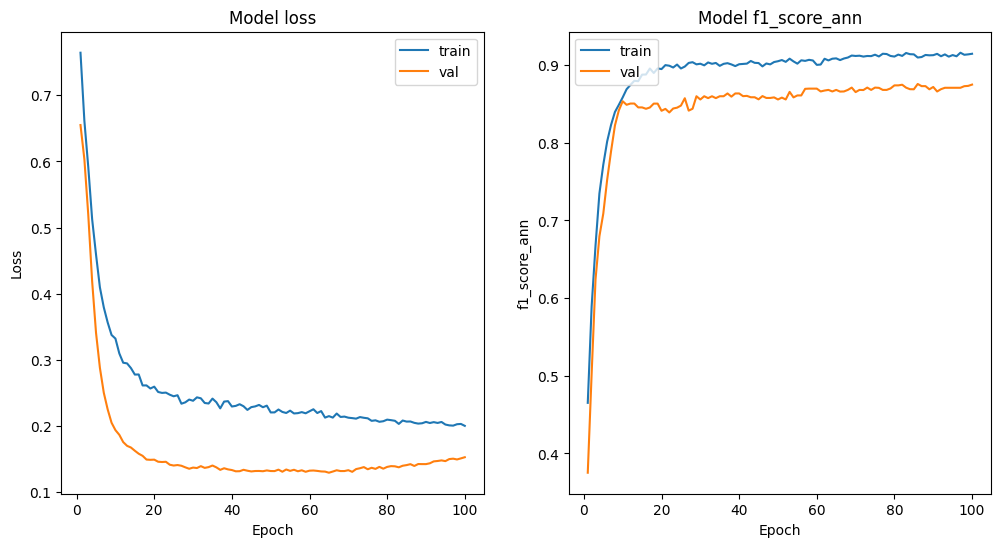

In [41]:
tf.keras.utils.set_random_seed(42)

dropout_rate = 0.75

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=24, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=24, activation='relu')

# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)
print(model_ann.summary())
#-----------------------------------------------------------------------------------------
from tensorflow.keras.optimizers import Adam
adam_custom = Adam(learning_rate=0.00051) # deafult 0.001

#-----------------------------------------------------------------------------------------
# compile model    

model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])

#---------------------------------------------------------------------------------------------

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10)
#early_stop = EarlyStopping(monitor='val_f1_score_ann', min_delta=1e-7, patience=20, mode='max')

# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=256,
                         verbose=0,
                         #callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))
#########################################################################################################################################################
#----------------------------------------------------------------------------------------------
# plot loss function and score of used metrics
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# plot training & validation loss values
axs[0].plot(range(1, len(hist_ann.history['loss']) + 1), hist_ann.history['loss'])
axs[0].plot(range(1, len(hist_ann.history['val_loss']) + 1), hist_ann.history['val_loss'])
axs[0].set(title='Model loss', ylabel='Loss', xlabel='Epoch')
axs[0].legend(['train', 'val'])

# plot training & validation metric score values
axs[1].plot(range(1, len(hist_ann.history[model_ann.metrics_names[1]]) + 1), hist_ann.history[model_ann.metrics_names[1]])
axs[1].plot(range(1, len(hist_ann.history['val_' + model_ann.metrics_names[1]]) + 1), hist_ann.history['val_' + model_ann.metrics_names[1]])
axs[1].set(title='Model ' + model_ann.metrics_names[1], ylabel=model_ann.metrics_names[1], xlabel='Epoch')
axs[1].legend(['train', 'val'], loc='upper left')

In [42]:
#-----------------------------------------------------------------------------------------------
# Predict and print classification report of validation data------------------------------------------------------------
y_pred = (model_ann.predict(X_val_scaled) > 0.5).astype('int8')
y_true = y_val
print(classification_report(y_true, y_pred, digits=4))

 1/59 [..............................] - ETA: 3s

59/59 [==============================] - 0s 789us/step
              precision    recall  f1-score   support

         0.0     0.9803    0.9947    0.9874      1698
         1.0     0.9427    0.8132    0.8732       182

    accuracy                         0.9771      1880
   macro avg     0.9615    0.9039    0.9303      1880
weighted avg     0.9766    0.9771    0.9764      1880



### ANN - Evaluation on Test Data

 1/59 [..............................] - ETA: 0s

59/59 [==============================] - 0s 720us/step
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9872    0.9959    0.9915      1708
         1.0     0.9551    0.8713    0.9113       171

    accuracy                         0.9846      1879
   macro avg     0.9712    0.9336    0.9514      1879
weighted avg     0.9843    0.9846    0.9842      1879

ROC_AUC_Score : 0.9862258104277086
------------------------------------------------------------


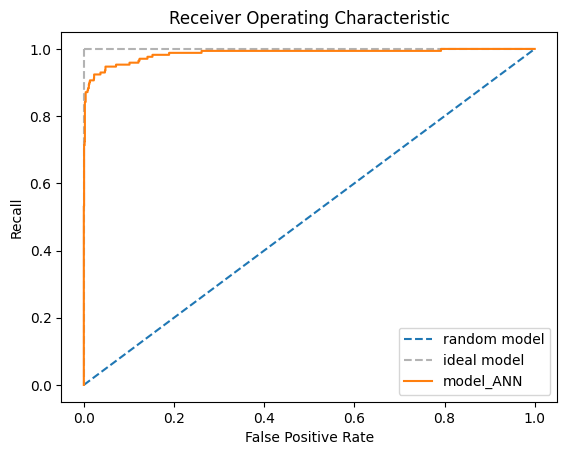

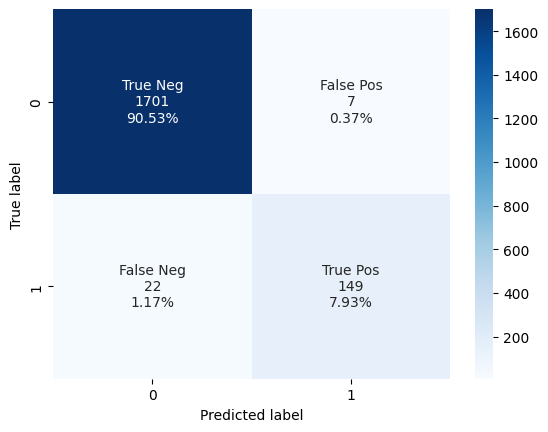

In [43]:
# predict on test data and print results --------------------------------------------------------------
y_pred = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba = model_ann.predict(X_test_scaled)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

In [44]:
model_results.append(calculate_scores(y_true, y_pred, name='ANN_Poly_PCA'))

pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,RF_Grid,0.971261,0.806283,0.900585,0.850829
1,SVM_Grid,0.975519,0.830688,0.918129,0.872222
2,ANN,0.978180,0.873563,0.888889,0.881159
3,ANN_Poly_PCA,0.984566,0.955128,0.871345,0.911315


### ANN - Hyperparameter Tuning - RandomizedSearchCV
To find the best hyperparameters, a random search approach using the KerasClassifier wrapper was implemented. The model architecture was encapsulated within the create_model function, allowing it to be used with scikit-learn's RandomizedSearchCV. The search was conducted on the specified hyperparameter space with a defined number of iterations. The code also ensured reproducibility by setting a random seed and defined the model's compilation, optimization, and scoring configurations. Overall, this implementation demonstrates the utilization of KerasClassifier for a randomized search to discover optimal hyperparameters for a neural network.

```python
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform



def create_model(dropout_rate, learning_rate, units):
    # set random seed
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(42)
    
    # define model
    model = Sequential()
    
    # define hidden layers
    model.add(Dense(units=units, activation='relu', input_dim=X_train_sampled.shape[1]))
    model.add(Dropout(rate=dropout_rate, seed=42))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(rate=dropout_rate, seed=42))
    
    # define output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # optimizer and compile model
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_score_ann])
    
    return model

# create Keras classifier for scikit-learn
model = KerasClassifier(build_fn=create_model, batch_size=256, epochs=100, learning_rate=0.001, verbose=0)

# define hyperparameters to search
from scipy.stats import uniform

search_space = {
    'dropout_rate': uniform(loc=0.5, scale=0.3),  
    'learning_rate': uniform(loc=0.0003, scale=0.002),  
    'batch_size': [256 ,512 ,1024], 
    'units': [8, 12, 16]
}

# perform randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=search_space,
    n_iter=30,
    scoring='f1', 
    cv=5,
)
#early_stop = EarlyStopping(monitor='val_f1_score_ann', min_delta=1e-6, patience=20, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10)

# fit the random search to your data
random_search.fit(X_train_sampled, y_train_sampled, callbacks = [early_stop], validation_data=(X_val_scaled, y_val))

# print best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

#predict and calculate probability
y_pred = (random_search.best_estimator_.predict(X_val_scaled) > 0.5).astype('int8')
y_true = y_val

print(classification_report(y_true, y_pred, digits=4))
```

### ANN - Save Model

In [106]:
# Save the fitted model to a single .h5 file in the models folder

save_flag = 0

if save_flag == 1:
    model_ann.save('models/ann.h5')

## Model Selection
The Artificial Neural Network with polynomial features and Principal Component Analysis was found to have the best performance in predicting pulsar stars. Even though there are only small differences in performance, the test data were best predicted. 
To simplify the data prediction, a separate Jupyter notebook Predictions.ipynb is used. In this notebook all necessary preprocessing steps are available, including the trained model

| name        | accuracy | precision | recall  | F1       |
|-------------|----------|-----------|---------|----------|
| RF_Grid     | 0.971261 | 0.806283  | 0.900585| 0.850829 |
| SVM_Grid    | 0.974987 | 0.826316  | 0.918129| 0.869806 |
| ANN         | 0.978180 | 0.873563  | 0.888889| 0.881159 |
| ANN_Poly_PCA| 0.984566 | 0.955128  | 0.871345| 0.911315 |


| name        | accuracy | precision | recall  | F1     |
|-------------|----------|-----------|---------|--------|
| RF_Grid     | 0.97     | 0.81      | 0.90    | 0.85   |
| SVM_Grid    | 0.97     | 0.83      | 0.92    | 0.87   |
| ANN         | 0.98     | 0.87      | 0.89    | 0.88   |
| ANN_Poly_PCA| 0.98     | 0.96      | 0.87    | 0.91   |
